## Import libraries

In [1]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from decimal import Decimal
import numpy as np
import glob
import importlib
import gc
import matplotlib.pyplot as plt
#from livelossplot import PlotLossesKeras
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle
import gc # Garbage Collector
import pandas as pd
from numpy import savez_compressed
from joblib import dump, load
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from pylab import rcParams
import itertools
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA

from keras.models import load_model
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential, load_model
from keras.layers import LSTM, TimeDistributed, BatchNormalization, ConvLSTM2D
from keras.layers.core import Dense, Flatten, Dropout, RepeatVector, Reshape, Dropout
from keras.layers.convolutional import Conv3D, Conv3DTranspose, MaxPooling3D
from keras.callbacks import ModelCheckpoint, EarlyStopping

#leakyrelu = lambda x: tf.keras.activations.relu(x, alpha=0.1)

def plot_loss(history):
  plt.figure(figsize=(16,8))
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  #plt.ylim([0, 0.4])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)
    
from platform import python_version
import keras
import tensorflow as tf

from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # True dynamically grow the memory used on the GPU
sess = tf.compat.v1.Session(config=config)
set_session(sess)

from tensorflow.python.client import device_lib
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print('Notebook running on Python', python_version())
print('Numpy version', np.version.version)
print('Keras version ', keras.__version__,'and TensorFlow', tf.__version__, '(CUDA:', tf.test.is_built_with_cuda(), '- GPUs available:', get_available_gpus(), ')')

Using TensorFlow backend.


Notebook running on Python 3.8.11
Numpy version 1.20.3
Keras version  2.3.1 and TensorFlow 2.2.0 (CUDA: True - GPUs available: [] )


## Load data from files

In [2]:
datasetRURpath = "dc21-rur-and-gpu-data/RUR/"
datasetGPUpath = "dc21-rur-and-gpu-data/GPU/"

### RUR

In [3]:
dfrur = pd.DataFrame()
files = glob.glob(datasetRURpath + "/20*.csv") 
for filename in files:
    data = pd.read_csv(filename)
    dfrur = dfrur.append(data, ignore_index=True)

In [4]:
dfrur['end_time'] = pd.to_datetime(dfrur['end_time'])
dfrur['start_time'] = pd.to_datetime(dfrur['start_time'])
dfrur["duration"] = (dfrur['end_time'] - dfrur['start_time']).dt.total_seconds()

In [5]:
dftask3 = dfrur
dfaux = dftask3[['start_time', 'node_count', 'max_rss', 'stime', 'utime', 'duration', 'gpu_maxmem', 'gpu_secs']]
dfaux.index = pd.to_datetime(dfaux['start_time'],format='%m/%d/%y %I:%M%p')
aux = dfaux.groupby(pd.Grouper(freq='M'))
datasetsum = aux.sum()
datasetmean = aux.mean()
datasetmax = aux.max()
datasetstd = aux.std()
monthcnt = aux.size()

In [8]:
print(datasetsum.index.min(), datasetsum.index.max())
print(datasetsum.index[5], datasetsum.index[-7])
print(len(datasetsum[5:-7]))

2015-03-31 00:00:00 2019-07-31 00:00:00
2015-08-31 00:00:00 2019-01-31 00:00:00
41


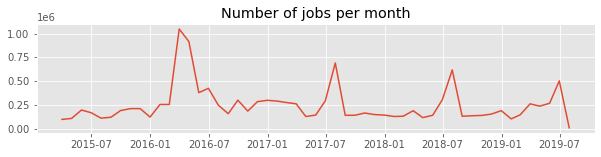

In [11]:
plt.style.use("ggplot")
plt.figure(figsize=(10,2))
plt.plot(monthcnt)
plt.title("Number of jobs per month", y=1)
plt.show()

<Figure size 1152x576 with 0 Axes>

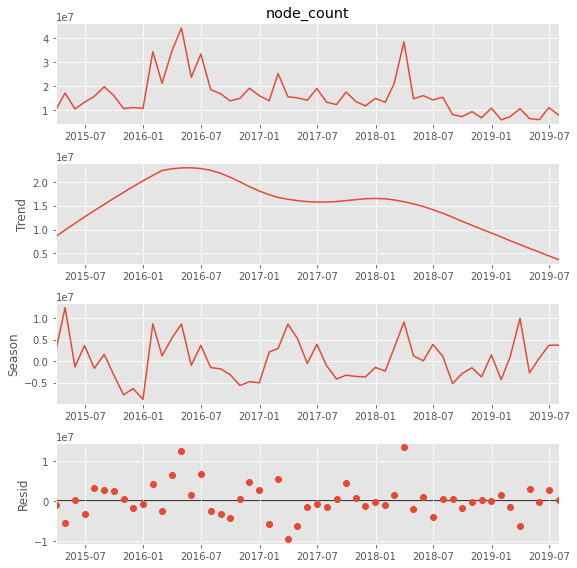

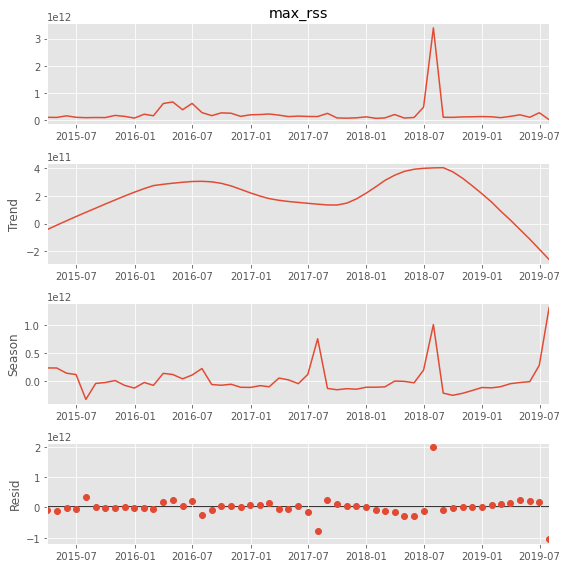

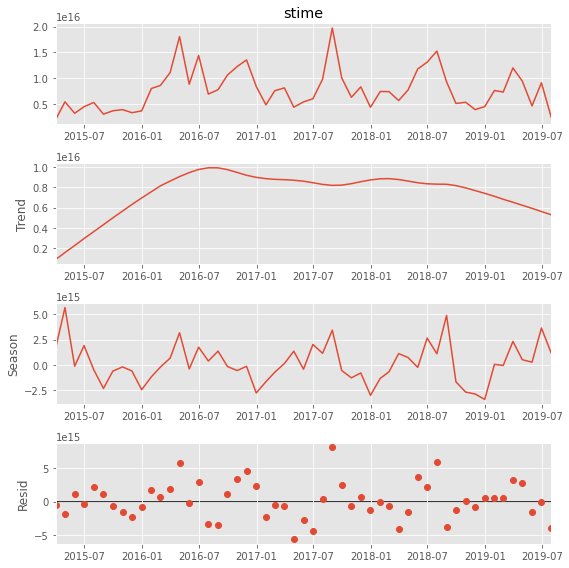

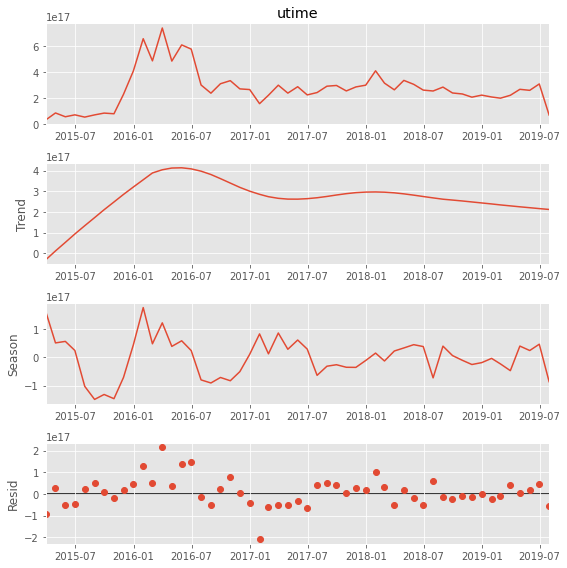

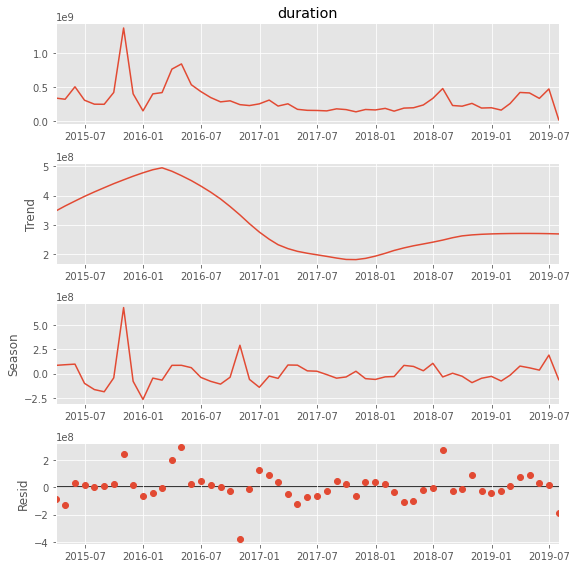

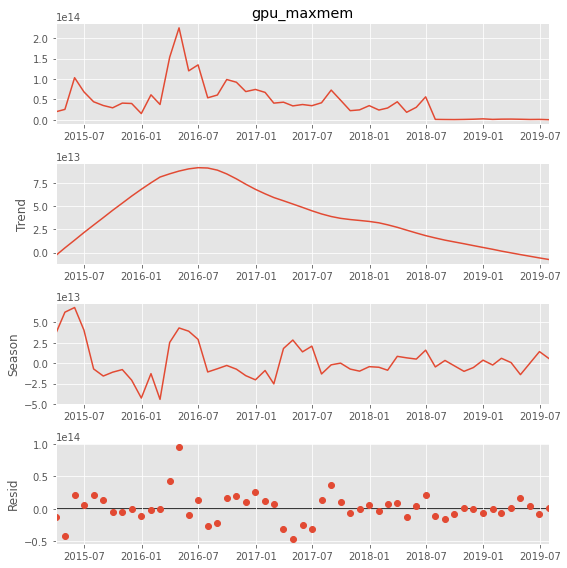

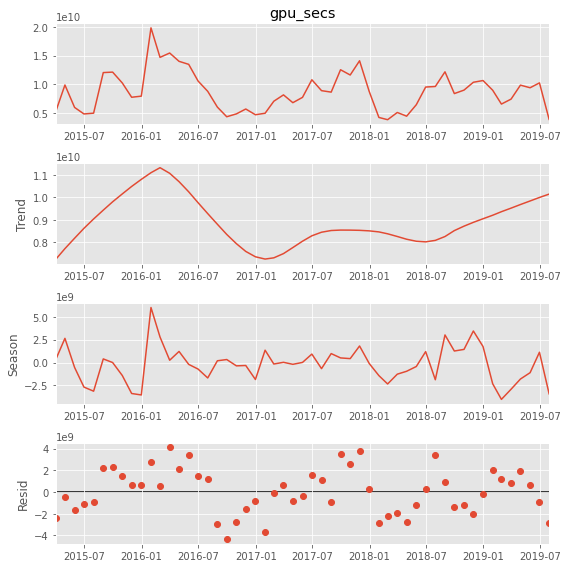

In [12]:
from statsmodels.tsa.seasonal import STL
from matplotlib.backends.backend_pdf import PdfPages

pp = PdfPages('sum.pdf')
dataset = datasetsum
plt.style.use("ggplot")
plt.figure(figsize=(16,8))
for i in range(0, len(dataset.columns)):
    y = dataset[dataset.columns[i]]
    rcParams['figure.figsize'] = 8, 8
    res = STL(y).fit()
    plot = res.plot()
    pp.savefig(plot)
plt.show()
pp.close()